In [1]:
import os
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from collections import defaultdict
from pathlib import Path
import itertools
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf

from diverse_gen.utils.exp_utils import get_conf_dir
from diverse_gen.utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results


In [3]:
MAIN_DIR = "output/cc_mix_rate/main"
NO_SCHED_DIR = "output/cc_mix_rate/no-sched"
INV_AGG_DIR = "output/cc_mix_rate/inv_agg"

RESULTS_DIR = "results/cc_mix_rate"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [4]:
SEEDS = [1, 2, 3]
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = [
    "toy_grid", 
    "fmnist_mnist", 
    "cifar_mnist", 
    "waterbirds", 
    "celebA-0", 
    "multi-nli"
]
METHODS = [
    "TopK_0.1", 
    "TopK_0.5", 
    "DivDis", 
    "DBAT", 
    "ERM"
]

In [5]:
def get_results(acc_metric: str, dir_path: str, methods: list[str], model_selection="val_loss"):
    results = defaultdict(lambda: defaultdict(list))
    for dataset, method in itertools.product(DATASETS, methods):
        exp_dirs = []
        mix_rates = MIX_RATES if method != "ERM" else [0.0]
        for mix_rate, seed in itertools.product(mix_rates, SEEDS):
            exp_dirs.append(get_conf_dir((dataset, method, mix_rate, seed), dir_path))
        perf_source_acc = dataset == "toy_grid"
        results[dataset][method] = get_acc_results(
            exp_dirs=exp_dirs, acc_metric=acc_metric, model_selection=model_selection, 
            perf_source_acc=perf_source_acc, verbose=True
        )
    # recusrively convert default dict to dict
    return results

In [6]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, method_dict in results.items():
        for method, mix_rate_dict in method_dict.items():
            for mix_rate, accuracies in mix_rate_dict.items():
                # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Method', 'Mix_Rate'], inplace=True)
    return df 

# Main Results

In [7]:
acc_results = get_results("test_acc", dir_path=MAIN_DIR, methods=METHODS)
alt_acc_results = get_results("test_acc_alt", dir_path=MAIN_DIR, methods=METHODS)
worst_acc_results = get_results("test_worst_acc", dir_path=MAIN_DIR, methods=METHODS)

In [8]:
acc_df = to_df(acc_results)
alt_acc_df = to_df(alt_acc_results)
worst_acc_df = to_df(worst_acc_results)

In [9]:
acc_df.to_csv(os.path.join(RESULTS_DIR, "acc_df.csv"), index=False)
alt_acc_df.to_csv(os.path.join(RESULTS_DIR, "alt_acc_df.csv"), index=False)
worst_acc_df.to_csv(os.path.join(RESULTS_DIR, "worst_acc_df.csv"), index=False)


In [10]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

# use standard matplotlib colors
color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHOD_COLORS = {
    "TopK_0.1": color_map[0], 
    "DivDis": color_map[1],
    "TopK_0.5": color_map[2], 
    "TopK_0.1_No_Sched": "#1e3d8f", 
    "TopK_0.5_No_Sched": "#556b2f", 
    "TopK_0.1_Inv_Agg": "#1e3d8f", 
    "TopK_0.5_Inv_Agg": "#556b2f", 
    "DBAT": color_map[3], 
    "ERM": color_map[4], 
}

DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

METHOD_TITLES = {
    "TopK_0.1": "TopK 0.1",
    "TopK_0.5": "TopK 0.5",
    "DivDis": "DivDis",
    "DBAT": "DBAT",
    "ERM": "ERM",
    "TopK_0.1_No_Sched": "TopK 0.1 Const",
    "TopK_0.5_No_Sched": "TopK 0.5 Const",
    "TopK_0.1_Inv_Agg": "TopK 0.1 Inv Agg",
    "TopK_0.5_Inv_Agg": "TopK 0.5 Inv Agg",
}

In [11]:
def plot_acc_results_grid(
    df: pd.DataFrame,
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple[float, float] = (6, 4),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = 10,
    tick_fontsize: int = 8,
    legend_fontsize: int = 8,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
    datasets: list[str] = DATASETS, 
    methods: list[str] = METHODS, 
    legend_bbox: tuple[float, float] = (0.5, 1.05), 
    method_linestyle: dict[str, str] = {},
    method_colors: dict[str, str] = METHOD_COLORS,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):  # Using global DATASETS
        ax = axes[idx]
        dataset_data = df[df['Dataset'] == dataset]
        
        for method in methods:  # Using global METHODS
            method_data = dataset_data[dataset_data['Method'] == method]
            
            if method == "ERM":
                # For ERM, calculate mean and std of all results
                mean_acc = method_data['Accuracy'].mean()
                std_acc = method_data['Accuracy'].std()
                means = [mean_acc] * len(MIX_RATES)
                stds = [std_acc] * len(MIX_RATES)
                line_style = '--'
                marker = None
            else:
                # For other methods, group by mix rate
                grouped = method_data.groupby('Mix_Rate')['Accuracy']
                means = []
                stds = []
                for rate in MIX_RATES: 
                    rate_data = grouped.get_group(rate)
                    means.append(rate_data.mean())
                    stds.append(rate_data.std())
                line_style = method_linestyle.get(method, '-')
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=METHOD_TITLES[method], marker=marker, linestyle=line_style, color=method_colors[method])
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2, 
                          color=method_colors[method])

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(dataset, dataset) if dataset_titles else dataset
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=legend_bbox, ncol=len(methods), fontsize=fontsize)

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

In [12]:
def plot_aggregate_metrics(
    df: pd.DataFrame,
    included_methods: list[str] = [],
    figsize: tuple[float, float] = (6, 3),
    save_path: Optional[str] = None,
    metric_col: str = 'Accuracy',
    ylim: tuple[float, float] = (-0.1, 1.0), 
    width: float = 0.75,  # Made width a parameter with a smaller default
    title: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    legend_bbox: tuple[float, float] = (0.5, 1), 
    method_colors: dict[str, str] = METHOD_COLORS,
):
    # Get ERM baseline for each dataset
    erm_baselines = df[df['Method'] == 'ERM'].groupby('Dataset')[metric_col].mean()
    
    # Filter for included methods and calculate differences from ERM baseline
    method_df = df[df['Method'].isin(included_methods)].copy()
    method_df['Accuracy_Diff'] = method_df.apply(
        lambda row: row[metric_col] - erm_baselines.get(row['Dataset'], 0), 
        axis=1
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set y-limits
    ax.set_ylim(ylim)

    # Calculate positions for box plots
    mix_rates = sorted(method_df['Mix_Rate'].unique())
    x = np.arange(len(mix_rates))
    x = x * (len(included_methods) + 1)  # Increase spacing between mix rate groups
    
    # Plot boxes for each method
    box_positions = []
    box_data = []
    labels = []
    colors = []
    
    for i, method in enumerate(included_methods):
        for j, mix_rate in enumerate(mix_rates):
            data = method_df[(method_df['Method'] == method) & 
                           (method_df['Mix_Rate'] == mix_rate)]['Accuracy_Diff']
            if len(data) > 0:
                pos = x[j] + width * (i - len(included_methods)/2 + 0.5)
                box_positions.append(pos)
                box_data.append(data)
                labels.append(METHOD_TITLES[method])
                colors.append(method_colors[method])

    # Create box plot
    boxes = ax.boxplot(box_data, positions=box_positions, patch_artist=True,
                      medianprops=dict(color='black'),
                      whiskerprops=dict(linestyle='--', color='black'),
                      flierprops=dict(marker='o', markerfacecolor='gray', markersize=4),
                      widths=width)  # Set box width
    
    # Color the boxes according to method
    for box, color in zip(boxes['boxes'], colors):
        box.set_facecolor(color)
        box.set_alpha(0.6)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    if ylabel is None: 
        ylabel = 'Accuracy Difference from ERM'
    ax.set_title(title)
    
    # Update x-axis ticks to be centered for each mix rate group
    # tick_positions = [x[i] + (len(included_methods) - 1) * width/2 for i in range(len(mix_rates))]
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mix Rate')

    # Create custom legend
    legend_elements = [Patch(facecolor=method_colors[method], alpha=0.6, label=METHOD_TITLES[method])
                      for method in included_methods]
    ax.legend(handles=legend_elements, bbox_to_anchor=legend_bbox, 
             loc='upper center', ncol=len(included_methods))

    plt.tight_layout()
    
    if save_path:
        base, ext = os.path.splitext(save_path)
        new_save_path = f"{base}_boxplot{ext}"
        plt.savefig(new_save_path, bbox_inches="tight", dpi=300)
    
    plt.show()
    
    return fig, ax

In [13]:
def plot_aggregate_metrics_violin(
    df: pd.DataFrame,
    included_methods: list[str] = [],
    figsize: tuple[float, float] = (6, 3),
    save_path: Optional[str] = None,
    metric_col: str = 'Accuracy',
    ylim: tuple[float, float] = (-0.1, 1.0), 
    width: float = 0.75,
    title: Optional[str] = None, 
    ylabel: Optional[str] = None, 
    legend_bbox: tuple[float, float] = (0.5, 1), 
    method_colors: dict[str, str] = METHOD_COLORS,
):
    # Get ERM baseline for each dataset
    erm_baselines = df[df['Method'] == 'ERM'].groupby('Dataset')[metric_col].mean()
    
    # Filter for included methods and calculate differences from ERM baseline
    method_df = df[df['Method'].isin(included_methods)].copy()
    method_df['Accuracy_Diff'] = method_df.apply(
        lambda row: row[metric_col] - erm_baselines.get(row['Dataset'], 0), 
        axis=1
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set y-limits
    ax.set_ylim(ylim)

    # Calculate positions for violin plots
    mix_rates = sorted(method_df['Mix_Rate'].unique())
    x = np.arange(len(mix_rates))
    x = x * (len(included_methods) + 1)  # Increase spacing between mix rate groups
    
    # Collect data for each method/mix_rate pair
    violin_positions = []
    violin_data = []
    colors = []
    
    for i, method in enumerate(included_methods):
        for j, mix_rate in enumerate(mix_rates):
            data = method_df[
                (method_df['Method'] == method) & 
                (method_df['Mix_Rate'] == mix_rate)
            ]['Accuracy_Diff']
            
            if len(data) > 0:
                pos = x[j] + width * (i - len(included_methods)/2 + 0.5)
                violin_positions.append(pos)
                violin_data.append(data)
                colors.append(method_colors[method])

    # Create violin plot
    violins = ax.violinplot(violin_data, positions=violin_positions, widths=width, showmedians=True)
    
    # Match the cmins, cmaxes, and cbars colors to the corresponding body colors
    violins['cbars'].set_edgecolors('none')
    violins['cbars'].set_linewidths(1)
    violins['cmins'].set_edgecolors('none')
    violins['cmins'].set_linewidths(1)
    violins['cmaxes'].set_edgecolors('none')
    violins['cmaxes'].set_linewidths(1)
    violins['cmedians'].set_edgecolors(colors)
    violins['cmedians'].set_linewidths(1.5)

    # Customize violin body appearance
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.6)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Set title, labels, and ticks
    if ylabel is None: 
        ylabel = 'Accuracy Difference from ERM'
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mix Rate')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{mr:.2f}' for mr in mix_rates], rotation=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Create legend
    legend_elements = [
        Patch(facecolor=method_colors[m], alpha=0.6, label=METHOD_TITLES[m])
        for m in included_methods
    ]
    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=legend_bbox, 
        loc='upper center',
        ncol=len(included_methods)
    )

    plt.tight_layout()
    
    # Optionally save
    if save_path:
        base, ext = os.path.splitext(save_path)
        new_save_path = f"{base}_violinplot{ext}"
        plt.savefig(new_save_path, bbox_inches="tight", dpi=300)
    
    plt.show()
    
    return fig, ax


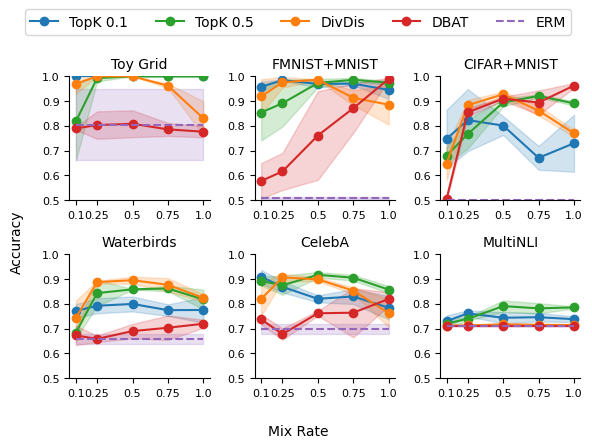

In [14]:
fig, axes = plot_acc_results_grid(
    acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

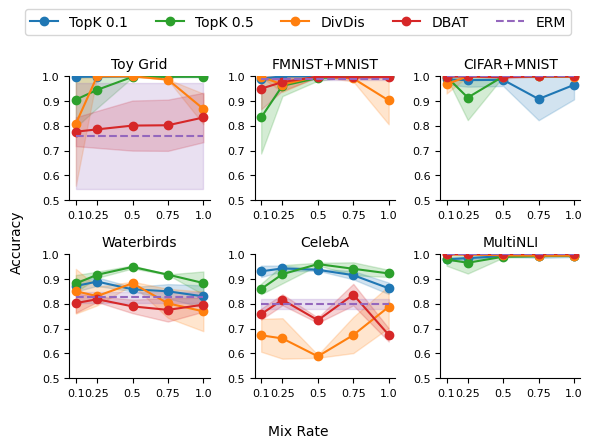

In [15]:
fig, axes = plot_acc_results_grid(
    alt_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "alt_acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

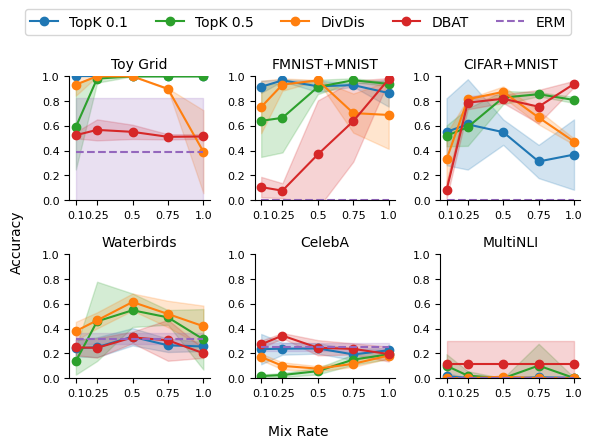

In [16]:
fig, axes = plot_acc_results_grid(
    worst_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    ylim=(0.0, 1.0),
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "worst_acc_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [17]:
avg_acc_df = pd.DataFrame()
avg_acc_df['Dataset'] = acc_df['Dataset']
avg_acc_df['Method'] = acc_df['Method']
avg_acc_df['Mix_Rate'] = acc_df['Mix_Rate']
avg_acc_df['Accuracy'] = (acc_df['Accuracy'] + alt_acc_df['Accuracy']) / 2

avg_acc_df.to_csv(os.path.join(RESULTS_DIR, "avg_acc_df.csv"), index=False)

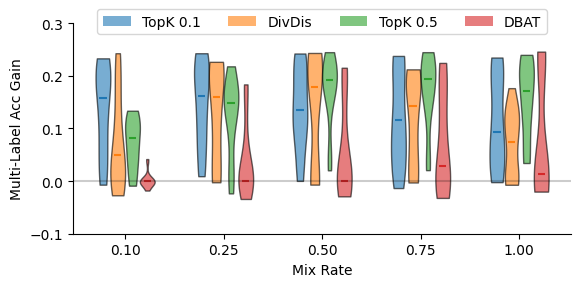

<Figure size 640x480 with 0 Axes>

In [18]:
# For average accuracy
fig, ax = plot_aggregate_metrics_violin(
    df=avg_acc_df,
    included_methods=["TopK_0.1", "DivDis", "TopK_0.5", "DBAT"],
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
plt.savefig(os.path.join(RESULTS_DIR, "avg_acc_violin.svg"), bbox_inches="tight", dpi=300)
plt.show()

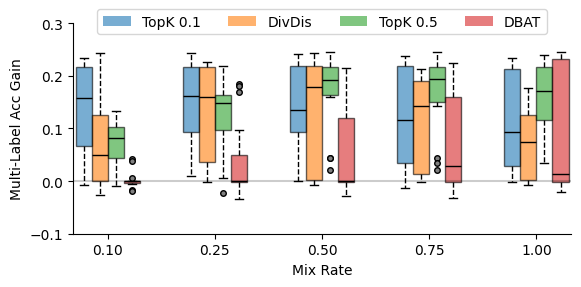

<Figure size 640x480 with 0 Axes>

In [19]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_df,
    included_methods=["TopK_0.1", "DivDis", "TopK_0.5", "DBAT"],
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
plt.savefig(os.path.join(RESULTS_DIR, "avg_acc_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

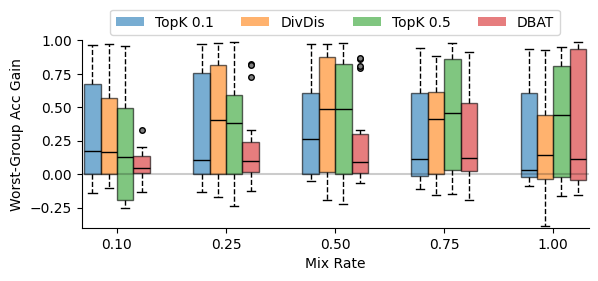

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plot_aggregate_metrics(
    df=worst_acc_df,
    included_methods=["TopK_0.1", "DivDis", "TopK_0.5", "DBAT"],
    metric_col='Accuracy',
    ylim=(-0.4, 1.0), 
    figsize=(6, 3), 
    title="", 
    ylabel="Worst-Group Acc Gain", 
    legend_bbox=(0.5, 1.2)
)
plt.savefig(os.path.join(RESULTS_DIR, "worst_acc_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

# No Sched Results

In [21]:
TOPK_METHODS = ["TopK_0.1", "TopK_0.5"]
TOPK_NO_SCHED_METHODS = [
    "TopK_0.1_No_Sched", 
    "TopK_0.5_No_Sched",
]


In [22]:
acc_results_topk = to_df(get_results("test_acc", dir_path=MAIN_DIR, methods=TOPK_METHODS + ["ERM"]))
alt_acc_results_topk = to_df(get_results("test_acc_alt", dir_path=MAIN_DIR, methods=TOPK_METHODS + ["ERM"]))
worst_acc_results_topk = to_df(get_results("test_worst_acc", dir_path=MAIN_DIR, methods=TOPK_METHODS + ["ERM"]))
acc_results_no_sched = to_df(get_results("test_acc", dir_path=NO_SCHED_DIR, methods=TOPK_NO_SCHED_METHODS))
alt_acc_results_no_sched = to_df(get_results("test_acc_alt", dir_path=NO_SCHED_DIR, methods=TOPK_NO_SCHED_METHODS))
worst_acc_results_no_sched = to_df(get_results("test_worst_acc", dir_path=NO_SCHED_DIR, methods=TOPK_NO_SCHED_METHODS))

In [23]:
acc_results_sched_ablat = pd.concat([acc_results_topk, acc_results_no_sched])
alt_acc_results_sched_ablat = pd.concat([alt_acc_results_topk, alt_acc_results_no_sched])
worst_acc_results_sched_ablat = pd.concat([worst_acc_results_topk, worst_acc_results_no_sched])

acc_results_sched_ablat.to_csv(os.path.join(RESULTS_DIR, "acc_results_sched_ablat.csv"), index=False)
alt_acc_results_sched_ablat.to_csv(os.path.join(RESULTS_DIR, "alt_acc_results_sched_ablat.csv"), index=False)
worst_acc_results_sched_ablat.to_csv(os.path.join(RESULTS_DIR, "worst_acc_results_sched_ablat.csv"), index=False)


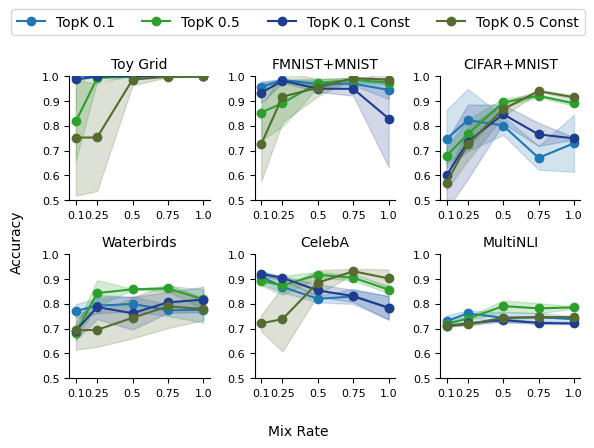

In [24]:
fig, axes = plot_acc_results_grid(
    acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

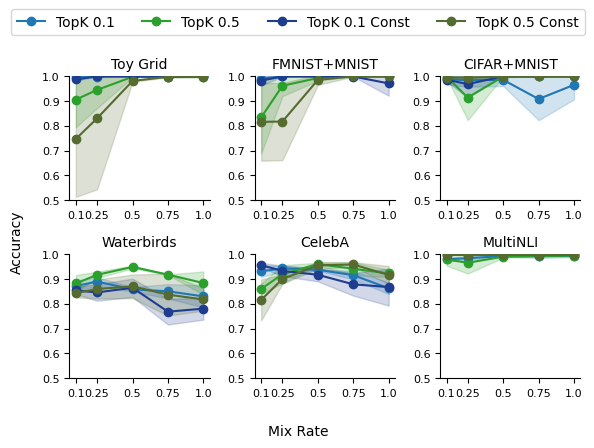

In [25]:
fig, axes = plot_acc_results_grid(
    alt_acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "alt_acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

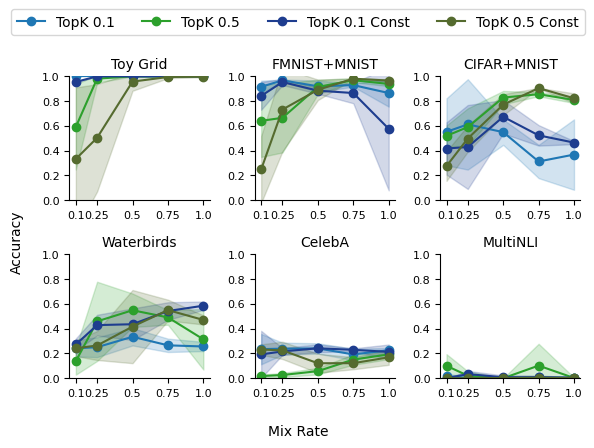

In [26]:
fig, axes = plot_acc_results_grid(
    worst_acc_results_sched_ablat, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_NO_SCHED_METHODS, 
    ylabel="Accuracy", 
    ylim=(0.0, 1.0),
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "worst_acc_results_sched_ablat_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [27]:
avg_acc_sched_ablat_df = pd.DataFrame()
erm_df = acc_results 
avg_acc_sched_ablat_df['Dataset'] = acc_results_sched_ablat['Dataset']
avg_acc_sched_ablat_df['Method'] = acc_results_sched_ablat['Method']
avg_acc_sched_ablat_df['Mix_Rate'] = acc_results_sched_ablat['Mix_Rate']

avg_acc_sched_ablat_df['Accuracy'] = (acc_results_sched_ablat['Accuracy'] + alt_acc_results_sched_ablat['Accuracy']) / 2

avg_acc_sched_ablat_df.to_csv(os.path.join(RESULTS_DIR, "avg_acc_sched_ablat_df.csv"), index=False)

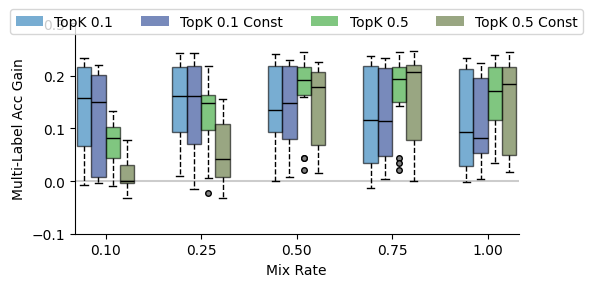

<Figure size 640x480 with 0 Axes>

In [28]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_sched_ablat_df,
    included_methods=sorted(TOPK_METHODS + TOPK_NO_SCHED_METHODS),
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
plt.savefig(os.path.join(RESULTS_DIR, "avg_acc_sched_ablat_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()

# Inv Agg Results

In [29]:
TOPK_METHODS = ["TopK_0.1", "TopK_0.5"]
TOPK_INV_AGG_METHODS = [
    "TopK_0.1_Inv_Agg", 
    "TopK_0.5_Inv_Agg",
]

acc_results_topk_inv_agg = to_df(get_results("test_acc", dir_path=INV_AGG_DIR, methods=TOPK_INV_AGG_METHODS))
alt_acc_results_topk_inv_agg = to_df(get_results("test_acc_alt", dir_path=INV_AGG_DIR, methods=TOPK_INV_AGG_METHODS))
worst_acc_results_topk_inv_agg = to_df(get_results("test_worst_acc", dir_path=INV_AGG_DIR, methods=TOPK_INV_AGG_METHODS))

acc_results_sched_ablat_inv_agg = pd.concat([acc_results_topk_inv_agg, acc_results_topk])
alt_acc_results_sched_ablat_inv_agg = pd.concat([alt_acc_results_topk_inv_agg, alt_acc_results_topk])
worst_acc_results_sched_ablat_inv_agg = pd.concat([worst_acc_results_topk_inv_agg, worst_acc_results_topk])

acc_results_sched_ablat_inv_agg.to_csv(os.path.join(RESULTS_DIR, "acc_results_sched_ablat_inv_agg.csv"), index=False)
alt_acc_results_sched_ablat_inv_agg.to_csv(os.path.join(RESULTS_DIR, "alt_acc_results_sched_ablat_inv_agg.csv"), index=False)
worst_acc_results_sched_ablat_inv_agg.to_csv(os.path.join(RESULTS_DIR, "worst_acc_results_sched_ablat_inv_agg.csv"), index=False)


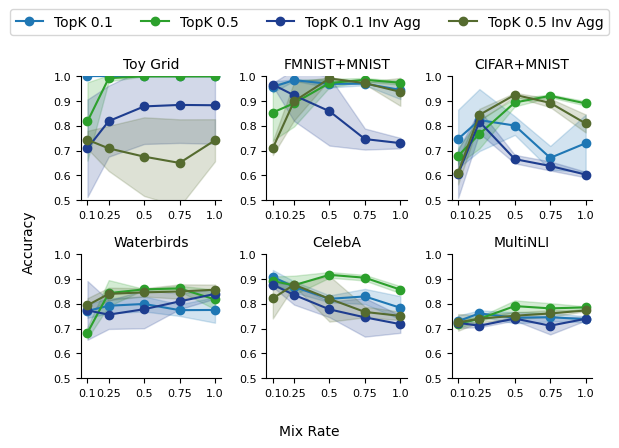

In [30]:
fig, axes = plot_acc_results_grid(
    acc_results_sched_ablat_inv_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_INV_AGG_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "acc_results_sched_ablat_inv_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

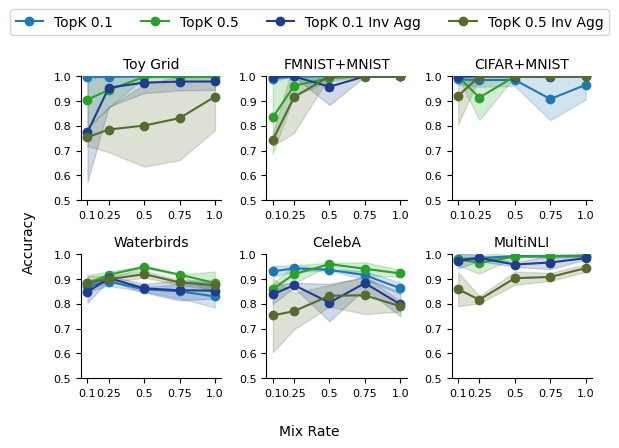

In [31]:
fig, axes = plot_acc_results_grid(
    alt_acc_results_sched_ablat_inv_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_INV_AGG_METHODS, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "alt_acc_results_sched_ablat_inv_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

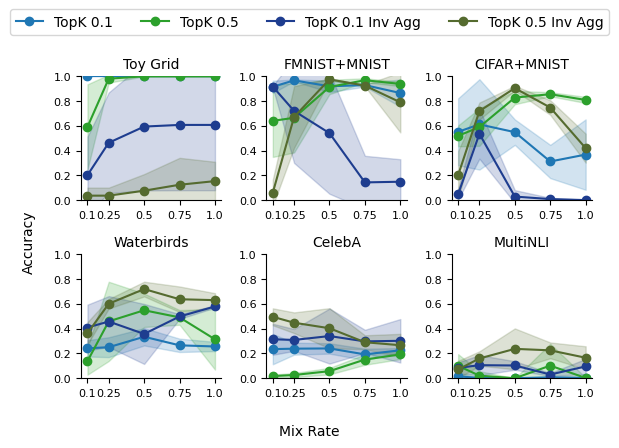

In [32]:
fig, axes = plot_acc_results_grid(
    worst_acc_results_sched_ablat_inv_agg, 
    dataset_titles=DATASET_TITLES, 
    methods=TOPK_METHODS + TOPK_INV_AGG_METHODS, 
    ylabel="Accuracy", 
    ylim=(0.0, 1.0),
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.savefig(os.path.join(RESULTS_DIR, "worst_acc_results_sched_ablat_inv_agg_grid.svg"), bbox_inches="tight", dpi=300)
plt.show()

In [33]:
avg_acc_inv_agg_df = pd.DataFrame()
erm_df = acc_results 
avg_acc_inv_agg_df['Dataset'] = acc_results_sched_ablat_inv_agg['Dataset']
avg_acc_inv_agg_df['Method'] = acc_results_sched_ablat_inv_agg['Method']
avg_acc_inv_agg_df['Mix_Rate'] = acc_results_sched_ablat_inv_agg['Mix_Rate']

avg_acc_inv_agg_df['Accuracy'] = (acc_results_sched_ablat_inv_agg['Accuracy'] + alt_acc_results_sched_ablat_inv_agg['Accuracy']) / 2

avg_acc_inv_agg_df.to_csv(os.path.join(RESULTS_DIR, "avg_acc_inv_agg_df.csv"), index=False)

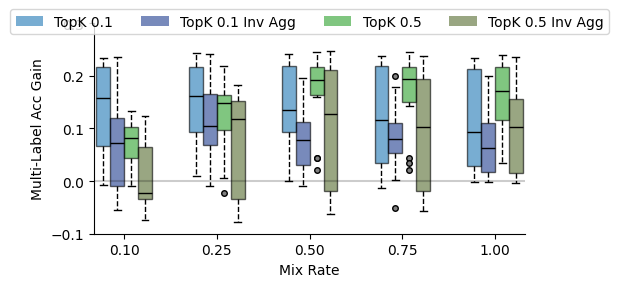

<Figure size 640x480 with 0 Axes>

In [34]:
# For average accuracy
fig, ax = plot_aggregate_metrics(
    df=avg_acc_inv_agg_df,
    included_methods=sorted(TOPK_METHODS + TOPK_INV_AGG_METHODS),
    metric_col='Accuracy',
    # use_quartiles=False, 
    ylim=(-0.1, 0.3), 
    figsize=(6, 3), 
    width=0.75,
    title="", 
    ylabel="Multi-Label Acc Gain", 
    legend_bbox=(0.5, 1.1)
)
plt.savefig(os.path.join(RESULTS_DIR, "avg_acc_inv_agg_boxplot.svg"), bbox_inches="tight", dpi=300)
plt.show()